# **RANDOM CLASSIFICATION TO TEST MODEL ROBUSTNESS**

## Loading Datasets

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import warnings

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid

In [2]:
cols = ['fileName','noun','fake','size','start','end']
indexer = pd.DataFrame(columns=cols)
df = pd.DataFrame(columns=range(1024))
listNouns = ['article','beard','blood','company','death','gun','id','interview','passport']
#Load NOUN datasets
for noun in listNouns:
    arrF = np.load('ELMOfiles/'+noun+'FAKE.npy')
    arrNF = np.load('ELMOfiles/'+noun+'.npy')
    
    count=len(df)
    df = df.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,True,arrF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    count=len(df)
    df = df.append(pd.DataFrame(arrNF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'.npy',noun,False,arrNF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    print("loaded for "+noun)

#-------------------------------------------------------------------------[FAKE]_NOUN_
#Define a dataframe that contains embeddings with FAKE
priv = ['beard','blood','company','death','gun']
indexer.insert(loc=3,column='privative',value=False)
for index, row in indexer.iterrows():
    if row['noun'] in priv:
        indexer.at[index,'privative']= True
        
priv_fakes_idx = indexer[(indexer.fake) & (indexer.privative)]
non_priv_fakes_idx = indexer[(indexer.fake==True) & (indexer.privative==False)]

fake_nouns = pd.DataFrame(columns=range(1024))
for index, row in indexer[indexer['fake']].iterrows():
    fake_nouns=fake_nouns.append(df.loc[row['start']:row['end']])

#affine this dataframe : add a 'priv' column
if 'priv' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['priv'])
    
fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'priv']= 1

#add 'noun' column
if 'noun' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['noun'])
    
fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']].iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'noun']= row['noun']

targets_Fnouns = fake_nouns['priv']
nouns_Fnouns = fake_nouns['noun']
X_Fnouns = fake_nouns.drop(columns=['priv','noun'])

#---------------------------------------------------------------------[NOT FAKE]_NOUN_
not_fake_nouns = pd.DataFrame(columns=range(1024))

priv_not_fakes_idx = indexer[(indexer.fake==False) & (indexer.privative)]

for index, row in indexer[indexer['fake']==False].iterrows():
    not_fake_nouns=not_fake_nouns.append(df.loc[row['start']:row['end']])

if 'priv' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['priv'])
    
not_fake_nouns.insert(loc=1024,column='priv',value=-1)
for index, row in priv_not_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'priv']= 1


if 'noun' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['noun'])
    
not_fake_nouns.insert(loc=1024,column='noun',value='')
for index, row in indexer[indexer['fake']==False].iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'noun']= row['noun']

targets_NFnouns = not_fake_nouns['priv']
nouns_NFnouns = not_fake_nouns['noun']
X_NFnouns = not_fake_nouns.drop(columns=['priv','noun'])

loaded for article
loaded for beard
loaded for blood
loaded for company
loaded for death
loaded for gun
loaded for id
loaded for interview
loaded for passport


In [3]:
cols = ['fileName','noun','size','start','end']
indexer_fakes = pd.DataFrame(columns=cols)
fakes_embd = pd.DataFrame(columns=range(1024))

for noun in listNouns:
    arrF = np.load('ELMOfiles/FAKE'+noun+'FAKE.npy')
    count=len(fakes_embd)
    fakes_embd = fakes_embd.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,arrF.shape[0],count,len(fakes_embd)-1]],columns=cols)
    indexer_fakes = indexer_fakes.append(d_temp,ignore_index=True)
    
    print("done for "+noun)
    
fakes_embd.index = X_Fnouns.index #re-indexing

if 'priv' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['priv'])
    
fakes_embd.insert(loc=1024,column='priv',value=fake_nouns['priv'])

if 'noun' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['noun'])
    
fakes_embd.insert(loc=1024,column='noun',value=fake_nouns['noun'])

targets_fakes = fakes_embd['priv']
nouns_fakes = fakes_embd['noun']
X_fakes = fakes_embd.drop(columns=['priv','noun'])

done for article
done for beard
done for blood
done for company
done for death
done for gun
done for id
done for interview
done for passport


In [4]:
# We extract 10% of the not_fake NOUNS dataset because it is too big for computations
not_fake_samples = not_fake_nouns.loc[not_fake_nouns.sample(int(len(not_fake_nouns)/10)).index.sort_values()]
#The preservation of class (nouns) proportions is ensured by the size of the sample (around 8700 items)
targets_nfs = not_fake_samples['priv']
nouns_nfs = not_fake_samples['noun']
X_nfs = not_fake_samples.drop(columns=['priv','noun'])
not_fake_samples

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,noun,priv
105,0.156440,0.392243,0.670808,0.017239,-0.791780,-0.307966,0.248630,0.756638,0.463805,-0.627815,...,0.305649,-0.135865,-0.271025,-0.151438,-0.234853,-0.049934,-1.069263,-0.391737,article,-1
112,0.001389,0.085758,-0.206224,0.260565,-0.452545,-0.281362,1.044623,0.543559,0.991329,0.229313,...,0.319981,-0.373213,-0.615894,0.271822,-0.657521,-0.538877,-1.375160,-0.441863,article,-1
117,1.105892,-0.487816,0.602358,-0.166988,-0.321126,-0.739577,1.126680,0.872510,1.027808,0.872063,...,0.458427,-0.005996,-0.043152,0.327320,-0.078642,-0.101164,-0.867164,-0.521396,article,-1
128,0.115704,-0.347319,-0.350481,0.170118,-0.759647,0.066949,0.748896,1.137835,0.820300,0.044535,...,0.130317,0.412327,0.014418,0.755649,-0.843460,-0.128049,-0.966879,-0.858058,article,-1
133,-0.044899,0.108831,-0.049638,-0.250247,-0.526304,-0.102664,0.656976,0.668502,-0.041566,-0.421197,...,-0.087243,0.133813,-0.076750,0.115744,-0.193680,0.264048,-0.795319,-0.907033,article,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87380,-0.137506,0.099917,-0.032697,0.161520,0.249910,0.403148,0.138841,0.546167,0.759870,-0.121248,...,0.698584,0.211146,0.066850,-0.222897,-0.150912,-0.376265,-1.074107,0.322007,passport,-1
87381,0.219394,0.449579,0.681783,0.283674,0.037013,0.920118,1.119931,1.174181,1.044679,0.028064,...,1.390398,-1.054640,0.440998,-0.254634,-0.286329,-0.700240,-0.582169,0.302576,passport,-1
87387,0.608585,-0.415489,0.836140,-0.999897,-0.867784,0.053833,-0.358101,0.382194,0.134095,0.161360,...,0.398527,0.178212,0.821113,0.791539,-0.015616,-0.229806,0.081768,0.328378,passport,-1
87407,-0.060577,-0.480153,-0.571447,-0.161473,-0.386373,0.639669,0.533180,0.443756,0.097704,0.006382,...,0.492267,-1.264138,0.734522,-0.145348,-0.375813,-0.590630,0.142282,0.518544,passport,-1


In [5]:
nouns_NFnouns.value_counts()

blood        11395
gun          11091
company      10802
article      10392
death        10323
interview    10133
id            9723
passport      9247
beard         3752
Name: noun, dtype: int64

## Datasets storage reminder : 
* [fake] **NOUN** : fake_nouns ; indexer ; X_Fnouns ; targets_Fnouns ; nouns_Fnouns
* [not fake] **NOUN** : not_fake_nouns ; indexer ; X_NFnouns ; targets_NFnouns ; nouns_NFnouns
* **sampled** [not fake] **NOUN** : not_fake_samples ; - ; X_nfs ; targets_nfs ; nouns_nfs
* **FAKE** : fakes_embd ; indexer_fakes ; X_fakes ; targets_fakes ; nouns_fakes

## Random Sampling

In [6]:
def random_labeling(tolerance,df,debug=False,rng=None,out_list=False):
    delta = tolerance*2
    while delta > tolerance:
        if rng:
            rand_classes = {listNouns[k]:rng.integers(0,2) for k in range(9)}
        else:
            rand_classes = {listNouns[k]:np.random.randint(2) for k in range(9)}
        rand_targets = pd.Series(data=np.ones(len(df))*-1,index=df.index)
        for i, embd in df.iterrows():
            if rand_classes[embd['noun']]==1:
                rand_targets[i]=1
        delta = np.abs(rand_targets.sum())
    if debug:
        print('sampling delta : ', delta)
        print(rand_targets.value_counts())
    if out_list:
        return (rand_targets, rand_classes)
    else:
        return rand_targets

sampling delta :  35.0
-1.0    317
 1.0    282
dtype: int64


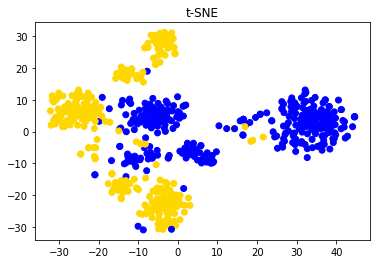

In [6]:
rand_targets = random_labeling(50,fakes_embd,True)
tsneX = TSNE(n_components=2, init='pca', random_state=0)
X_trans = tsneX.fit_transform(X_fakes).T

colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_trans[0], X_trans[1], color=rand_targets.map(colors_classes))
plt.title("t-SNE")
plt.axis('tight')
plt.show()

## Functions to test robustness

### Banned Noun Classification (BNC)

In [7]:
def Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess=None,k=2,show_kbest=False):
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    else:
        model = classifier
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    Tacc = np.sum(Ttrain == y_train)/len(Xtrain)
    y_banned = model.predict(Xbanned)
    Bacc = np.sum(Tbanned == y_banned)/len(Xbanned)
    return (Tacc,Bacc)

def BNC_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,full_output=False,debug=False,show_kbest=False):
    if debug:
        print("\rTest {} : BNC  starting%                     ".format(debug), end="")
        sys.stdout.flush()
    Taccs = np.zeros(len(listNouns))
    Baccs = np.zeros(len(listNouns))
    
    for i,bannedW in enumerate(listNouns):
        if debug:
            print("\rTest {} : BNC for {} ; {}%             ".format(debug, bannedW, 100 * i // len(listNouns)), end="")
            sys.stdout.flush()
        Xtrain = X[nouns!=bannedW]
        Ttrain = targets[nouns!=bannedW]
        if preprocess=='kbest':
            select = SelectKBest(MIC,k).fit(Xtrain,Ttrain)
            scaler = Scaler()
            Xtrain = scaler.fit_transform(select.transform(Xtrain))
            if show_kbest:
                print("({})".format(np.where(select.get_support())[0]))
        Xbanned = X[nouns==bannedW]
        if preprocess == 'kbest':
            Xbanned = scaler.transform(select.transform(Xbanned))
        Tbanned = targets[nouns==bannedW]
        Tacc,Bacc = Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess,k,show_kbest)
        Taccs[i],Baccs[i] = Tacc, Bacc
    AvgTrain = np.mean(Taccs)
    AvgBanned = np.mean(Baccs)
    if full_output:
        return (Taccs,Baccs)
    else:
        return (AvgTrain,AvgBanned)

### Classical Train/Test split and classification

In [8]:
def classical_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,out_model=False):
    #model selection
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    elif preprocess=='kbest local' or preprocess=='kbest global':
        model = make_pipeline(SelectKBest(MIC,k),Scaler(),classifier)
    else:
        model = classifier
    #The training set should be balanced in term of repartition of nouns
    Xtrain,Xtest,Ttrain,Ttest =train_test_split(X, targets, test_size=0.25, random_state=0, stratify=nouns,shuffle=True)
    #model training and predictions
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    y_test = model.predict(Xtest)
    #accuracies
    Train_acc = np.sum(Ttrain == y_train)/len(Xtrain)
    Test_acc = np.sum(Ttest == y_test)/len(Xtest)
    if out_model:
        return (Train_acc,Test_acc,model)
    else:
        return (Train_acc,Test_acc)

In [9]:
priv = ['beard','blood','company','death','gun']
non_priv = ['article','id','interview','passport']

In [10]:
delta_not_fake = np.sum(nouns_nfs.value_counts()[priv])-np.sum(nouns_nfs.value_counts()[non_priv])
delta_fake = np.abs(np.sum(nouns_fakes.value_counts()[priv])-np.sum(nouns_fakes.value_counts()[non_priv]))
print('% of original unbalancing : {}% in NOT FAKE ; {}% in FAKE'.format(delta_not_fake*100//len(nouns_nfs), delta_fake*100//len(nouns_fakes)))

% of original unbalancing : 8% in NOT FAKE ; 3% in FAKE


In [11]:
datasets = {'FAKES': [fakes_embd, X_fakes,targets_fakes, nouns_fakes],
            'fake NOUNS': [fake_nouns, X_Fnouns, targets_Fnouns, nouns_Fnouns],
            'not fake NOUNS': [not_fake_samples, X_nfs, targets_nfs, nouns_nfs]
           }
nb_tests = 8

In [12]:
def random_classif_process(classifier,clf_name,nb_tests,preprocess=None,k=2):
    print("============================================ {} =============================================".format(clf_name.upper()))
    for category in datasets.keys():
        print('--------------------------{}--------------------------'.format(category))
        embeddings,X,T,N = datasets[category]
        if preprocess=='tsne':
            tsne = TSNE(n_components=k)
            X = tsne.fit_transform(X)
        Taccs, Gaccs = np.zeros((2,nb_tests))
        BNC_Taccs, Baccs = np.zeros((2,nb_tests))
        for i in range(nb_tests):
            print("\rTest {} : random sampling            ".format(i+1), end="")
            sys.stdout.flush()
            rand_T = random_labeling(int(len(embeddings)*0.09),embeddings) #we have a tolerance of 9% the size of the dataset, since it is the difference maximum we observed in the original class repartition
            print("\rTest {} : random classif              ".format(i+1), end="")
            sys.stdout.flush()
            Taccs[i], Gaccs[i] = classical_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k)
            BNC_Taccs[i], Baccs[i] = BNC_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k,debug=i+1)
        print('\rAverage train accuracy : {}%   ( {}  )'.format(np.mean(Taccs).round(4)*100,np.std(Taccs).round(4)*100))
        print('Average test accuracy : {}%   ( {}  )'.format(np.mean(Gaccs).round(4)*100,np.std(Gaccs).round(4)*100))
        print('\rAverage BNC train accuracy : {}%   ( {}  )'.format(np.mean(BNC_Taccs).round(4)*100,np.std(BNC_Taccs).round(4)*100))
        print('Average BNC test accuracy : {}%   ( {}  )'.format(np.mean(Baccs).round(4)*100,np.std(Baccs).round(4)*100))

In [12]:
def partition(n):
    buffer = []
    if n==1:
        return [[0],[1]]
    sub_list=partition(n-1)
    for part in sub_list:
        buffer.append([0]+part.copy())
        buffer.append([1]+part.copy())
    return buffer

## Visualization of a random classification

We will use FAKE embeddings

In [535]:
# # Looking for a random key that output the original separation
# privativity_dict = {'article': 0, 'beard': 1, 'blood': 1, 'company': 1, 'death': 1, 'gun': 1, 'id': 0, 'interview': 0, 'passport': 0}
# non_privativity_dict = {n:0**privativity_dict[n] for n in privativity_dict}

# i=0
# rng = np.random.default_rng(i)
# rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)

# while rand_dict != privativity_dict and rand_dict != non_privativity_dict:
#     i+=1
#     rng = np.random.default_rng(i)
#     rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
# print(i)

In [13]:
warnings.filterwarnings('ignore') #ignore FutureWarnings

{'article': 0, 'beard': 0, 'blood': 1, 'company': 1, 'death': 0, 'gun': 1, 'id': 0, 'interview': 0, 'passport': 1}


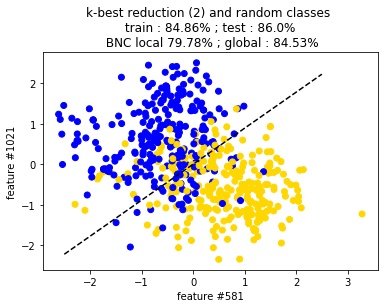

In [43]:
rng = np.random.default_rng(42) #set 26 to get original class division

#Choose if you want a controlled rng or not
#rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,out_list=True)

print(rand_dict)

Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes,preprocess='kbest local',k=2,out_model=True)
#_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes, preprocess='kbest local',k=2,debug=1)
#_, Gbl_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes, preprocess='kbest global',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=rand_T.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and random classes \n train : {}% ; test : {}% \n BNC local {}% ; global : {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100,Gbl_Bacc.round(4)*100))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

Test 1 : BNC for passport ; 88%              

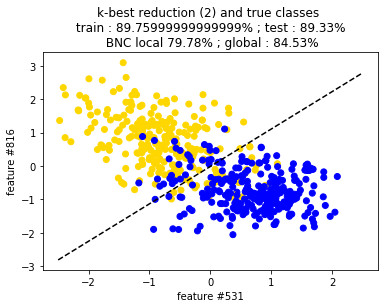

In [19]:
Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes,preprocess='kbest local',k=2,out_model=True)
_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest local',k=2,debug=1)
_, Gbl_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest global',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=targets_fakes.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and true classes \n train : {}% ; test : {}% \n BNC local {}% ; global : {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100,Gbl_Bacc.round(4)*100))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

In [25]:
BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest local',k=10,debug=2,show_kbest=True)

Test 2 : BNC for article ; 0%               ([531 617 678 727 793 816 864 914 979 999])
Test 2 : BNC for beard ; 11%             ([531 616 685 816 861 864 878 897 914 985])
Test 2 : BNC for blood ; 22%             ([531 620 710 802 816 864 866 897 902 914])
Test 2 : BNC for company ; 33%             ([531 695 789 816 864 878 897 914 979 985])
Test 2 : BNC for death ; 44%             ([531 678 726 789 816 822 864 878 914 979])
Test 2 : BNC for gun ; 55%             ([531 678 816 822 864 878 897 914 979 985])
Test 2 : BNC for id ; 66%             ([531 687 745 789 816 822 840 878 985 999])
Test 2 : BNC for interview ; 77%             ([531 678 726 789 816 864 878 897 914 985])
Test 2 : BNC for passport ; 88%             ([531 678 710 740 816 866 868 878 897 979])


(0.9562665929837214, 0.823032786644227)

In [497]:
selector = SelectKBest(MIC,2)
X_trans = Scaler().fit_transform(selector.fit_transform(X_fakes,rand_T))
print("\r{}".format(np.where(selector.get_support())[0]))
BNC_accuracy(classifier,X_trans,rand_T,nouns_fakes)

[676 985]


(0.8607260725479077, 0.7250925658136687)

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions WITH 2-KBEST (LINEAR SVM)

In [13]:
warnings.filterwarnings('ignore')

In [14]:
combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [16]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [21]:
part = valid_parts[0]

part_classes = {listNouns[k]:part[k] for k in range(9)}
part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
for i, embd in fakes_embd.iterrows():
    if part_classes[embd['noun']]==1:
        part_targets[i]=1
print(BNC_accuracy(LinearSVC(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2,debug=1))

part = valid_parts[-1]
part_classes = {listNouns[k]:part[k] for k in range(9)}
part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
for i, embd in fakes_embd.iterrows():
    if part_classes[embd['noun']]==1:
        part_targets[i]=1
print(BNC_accuracy(LinearSVC(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2,debug=2))


#The result is the same for a partition or its reverse ! So we does not need to count the symetric ones.

Test 1 : BNC for passport ; 88%              (0.9198580035878958, 0.5828963614163383)
Test 2 : BNC for passport ; 88%              (0.9198580035878958, 0.5828963614163383)


In [17]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=2)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=2,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [18]:
np.max(FAKES_BNC_scores)

0.7977901546288577

In [19]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>0.71]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.7978 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7891 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.7534 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20


In [20]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>0.71]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.9468 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7306 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.7182 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12


In [45]:
listNouns

['article',
 'beard',
 'blood',
 'company',
 'death',
 'gun',
 'id',
 'interview',
 'passport']

In [44]:
valid_parts[23]

[1, 0, 0, 0, 1, 1, 1, 0, 0]

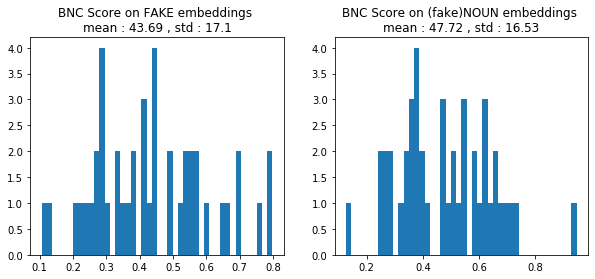

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [22]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4369, 0.1713])

In [23]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4772, 0.1653])

In [41]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  8
nb of valid partitions :  138


In [42]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=2)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=2,debug=ind+1)


Test 41 : BNC for death ; 44%                 

KeyboardInterrupt: 

In [ ]:
np.max(NFNOUNS_BNC_scores)

In [ ]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>0.71]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

In [ ]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_ELMo_kbest.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions WITH 10-KBEST (LINEAR SVM)

In [15]:
warnings.filterwarnings('ignore')

In [16]:

combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [17]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [20]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=10)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=10,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [21]:
np.max(FAKES_BNC_scores)

0.823032786644227

In [22]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>np.mean(FAKES_BNC_scores)]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.823 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7195 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.6576 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.6518 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.6399 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.6227 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.6026 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.5983 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.5762 [1, 1, 1, 0, 0, 1, 0, 0, 0] 5
0.5396 [0, 0, 1, 1, 1, 1, 0, 1, 0] 27
0.5371 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5304 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.5239 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14
0.5165 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.5124 [1, 1, 1, 0, 0, 0, 0, 0, 0] 0
0.5021 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.4926 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.4708 [0, 0, 1, 0, 1, 0, 1, 1, 0] 34
0.46 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.4445 [1, 1, 0, 1, 1, 0, 1, 0, 0] 13
0.4416 [1, 1, 1, 1, 0, 0, 0, 0, 0] 1
0.4276 [0, 1, 1, 1, 0, 0, 1, 0, 0] 11


In [23]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>np.mean(FNOUNS_BNC_scores)]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.8206 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.7162 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.701 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.6805 [1, 1, 0, 1, 0, 0, 1, 1, 0] 31
0.6792 [0, 0, 1, 1, 0, 0, 1, 1, 0] 32
0.6724 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.6702 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.6317 [0, 1, 1, 1, 0, 0, 1, 0, 0] 11
0.6262 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.6194 [0, 0, 1, 0, 1, 1, 1, 0, 0] 18
0.6067 [0, 0, 1, 0, 1, 0, 1, 1, 0] 34
0.6054 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.5844 [0, 0, 1, 1, 0, 1, 1, 1, 0] 40
0.5521 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.5322 [1, 0, 1, 0, 1, 1, 0, 0, 0] 8
0.5234 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.5053 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5001 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.4966 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.4957 [1, 1, 0, 1, 1, 1, 1, 0, 0] 19
0.4766 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.4719 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.4693 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.4684 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28


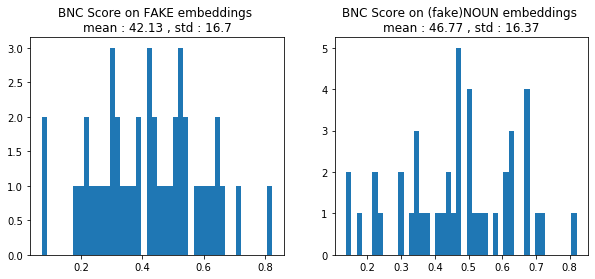

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [25]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4213, 0.1669])

In [26]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4677, 0.1637])

In [27]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<=int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  9
nb of valid partitions :  138


In [28]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=10)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=10,debug=ind+1)


Test 69 : BNC for passport ; 88%              

In [29]:
np.max(NFNOUNS_BNC_scores)

0.8371000451914827

In [30]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>np.mean(NFNOUNS_BNC_scores)]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.8371 [1, 0, 0, 1, 0, 0, 1, 1, 0] 51
0.7962 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7876 [1, 0, 0, 0, 1, 1, 0, 1, 0] 43
0.7647 [1, 0, 1, 0, 1, 0, 0, 1, 0] 32
0.7499 [1, 0, 0, 0, 1, 0, 1, 1, 0] 55
0.7286 [1, 1, 1, 0, 1, 1, 0, 0, 0] 5
0.7151 [1, 1, 0, 1, 0, 0, 1, 1, 0] 52
0.632 [0, 0, 1, 1, 1, 0, 0, 1, 0] 36
0.6307 [1, 1, 0, 1, 0, 1, 0, 1, 0] 41
0.6288 [1, 1, 1, 0, 0, 1, 1, 0, 0] 19
0.6097 [0, 1, 1, 0, 1, 0, 1, 1, 0] 58
0.609 [1, 0, 0, 1, 1, 0, 0, 1, 0] 34
0.6052 [1, 1, 1, 0, 0, 0, 1, 1, 0] 50
0.5814 [1, 0, 1, 1, 1, 0, 0, 0, 0] 0
0.5704 [1, 1, 0, 0, 1, 1, 0, 1, 0] 44
0.5652 [0, 0, 1, 1, 1, 1, 0, 0, 0] 8
0.5586 [0, 1, 1, 0, 1, 1, 1, 0, 0] 27
0.5585 [0, 1, 1, 1, 0, 1, 1, 0, 0] 23
0.5577 [1, 1, 1, 0, 1, 0, 0, 1, 0] 33
0.5483 [1, 1, 1, 1, 1, 0, 0, 0, 0] 1
0.5297 [0, 0, 0, 1, 1, 0, 1, 1, 0] 59
0.528 [0, 1, 1, 1, 1, 0, 0, 1, 0] 37
0.4913 [1, 0, 0, 0, 0, 1, 1, 1, 0] 61
0.4874 [1, 1, 0, 1, 1, 0, 0, 1, 0] 35
0.4856 [1, 1, 0, 1, 1, 1, 0, 0, 0] 7
0.4717 [0, 1, 0, 1, 1, 1, 1, 0

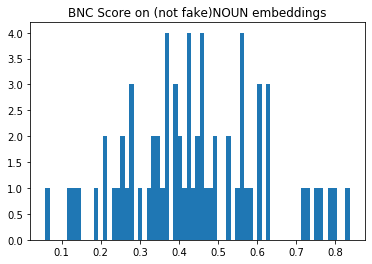

In [31]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

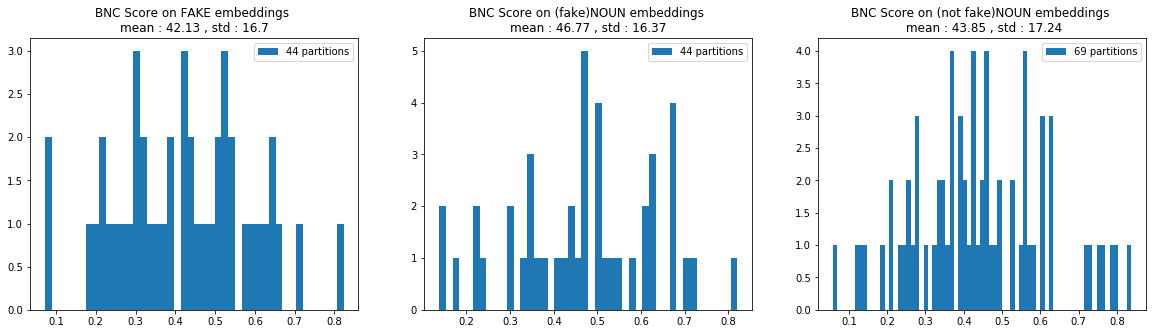

In [32]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_ELMo_kbest_10.png',dpi=300)
plt.show()

In [33]:
warnings.filterwarnings('default')

In [34]:
print(FAKES_BNC_scores[9],FNOUNS_BNC_scores[9],NFNOUNS_BNC_scores[9])

0.823032786644227 0.6261619936919357 0.7961876244826135


## Testing all random partitions with 2-KBEST (Nearest Neighbors)

In [16]:
warnings.filterwarnings('ignore')

In [17]:
combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [18]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [21]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=2)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=2,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [22]:
np.max(FAKES_BNC_scores)

0.8410947505012909

In [23]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>np.mean(FAKES_BNC_scores)]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.8411 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.8209 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7606 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.7191 [0, 0, 1, 1, 1, 1, 0, 1, 0] 27
0.6987 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.695 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.6798 [1, 1, 1, 0, 0, 0, 0, 0, 0] 0
0.632 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.63 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.6286 [1, 1, 1, 1, 0, 0, 0, 0, 0] 1
0.6192 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.6012 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.5859 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.5634 [1, 1, 1, 0, 0, 1, 0, 0, 0] 5
0.5508 [0, 0, 1, 0, 1, 0, 1, 1, 0] 34
0.5473 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5314 [0, 1, 1, 1, 0, 0, 1, 0, 0] 11
0.5209 [1, 1, 0, 1, 1, 1, 1, 0, 0] 19
0.5123 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.4929 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26


In [24]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>np.mean(FNOUNS_BNC_scores)]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.9532 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7489 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.7153 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.6973 [0, 0, 1, 0, 1, 1, 1, 0, 0] 18
0.6956 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.6842 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.6825 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.6802 [1, 0, 0, 0, 1, 1, 1, 1, 0] 41
0.6785 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.6427 [1, 1, 0, 0, 0, 1, 1, 1, 0] 37
0.6366 [0, 0, 1, 1, 0, 1, 1, 1, 0] 40
0.6111 [1, 1, 0, 1, 0, 0, 1, 1, 0] 31
0.6039 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.5812 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.5726 [0, 1, 1, 1, 0, 0, 1, 0, 0] 11
0.5688 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.5548 [1, 0, 1, 0, 1, 1, 0, 0, 0] 8
0.5493 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.5473 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5381 [0, 0, 1, 1, 0, 0, 1, 1, 0] 32
0.5354 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.5282 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.5164 [0, 0, 1, 0, 0, 1, 1, 1, 0] 38


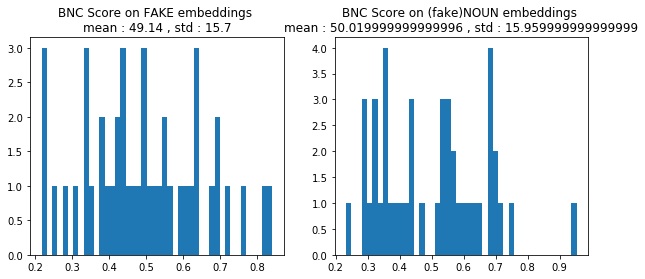

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [26]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4914, 0.1571])

In [27]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.5002, 0.1596])

In [28]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<=int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  8
nb of valid partitions :  138


In [ ]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=2)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=2,debug=ind+1)


Test 60 : BNC for passport ; 88%              

In [ ]:
np.max(NFNOUNS_BNC_scores)

In [ ]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>np.mean(NFNOUNS_BNC_scores)]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

In [ ]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_ELMo_kbest_2_NN.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')